# Process of Benchmarking data

In [1]:
from IPython.display import clear_output
# !pip install forest-benchmarking
clear_output()

In [2]:
from functions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit

In [3]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

In [4]:
# target_qubits = [41,42]
target_qubits = [0]
n_qubits = len(target_qubits)

k_m = 200 #number of sequences
n_m = 500 #number of shots

epsilon = 0.01
machine_title = '1q-qvm'
# machine_title = 'Aspen-M-3'
# noise_model = 'depolarising_noise'
noisy_machine = machine_title

noisy_machine = 'depolarising_noise' + '_epsilon{}'.format(epsilon)
# noise_model = 'z_noise'
path = os.path.join( os.getcwd(), 'output_storage', noisy_machine)

In [5]:
path

'C:\\Users\\mohsen\\Documents\\Python_pros\\git_controlled\\Randomized_Benchmarking_protocol\\output_storage\\depolarising_noise_epsilon0.01'

In [6]:
avg_fdlty_dict = {}
err_fdlty_dict = {}
ordered_layers_dict = {}

In [7]:
def capture_bench_dataframe(path):
    dataframe = pd.read_csv(os.path.join(path, '{}.csv'.format(machine_title) ) )
    dataframe = dataframe[dataframe['target qubits'] == str(target_qubits)]
    return dataframe

def filter_large_errors(dataframe):
    return dataframe[dataframe['error of fidelity'] <= 0.05]

def filter_seqs_shots_num(dataframe, sequences_num, shots_num):
    df = dataframe[dataframe['number of shots'] == shots_num]
    df = dataframe[dataframe['number of sequences'] == sequences_num]
    return df

def capture_bench_arrays(dataframe, version_name):
    dataframe = dataframe[ dataframe['protocol name'] == version_name ]
    ordered_layers = dataframe['circuit depth']
    avg_fdlty_arr = dataframe['average of fidelity']
    err_fdlty_arr = dataframe['error of fidelity']
    return ordered_layers, avg_fdlty_arr, err_fdlty_arr

In [8]:
df = capture_bench_dataframe(path)

In [9]:
df = filter_large_errors(df)
df = filter_seqs_shots_num(df, sequences_num=k_m, shots_num=n_m)

In [10]:
bench_versions = df['protocol name'].unique()
for version in bench_versions:
    avg_fdlty_dict[version] = []
    err_fdlty_dict[version] = []
    ordered_layers_dict[version] = []

    try:
        ordered_layers, avg_fdlty_arr, err_fdlty_arr = capture_bench_arrays(df, version)
        avg_fdlty_dict[version] = avg_fdlty_arr
        err_fdlty_dict[version] = err_fdlty_arr
        ordered_layers_dict[version] = ordered_layers
    except:
        pass

In [11]:
df

,date,target qubits,number of sequences,number of shots,protocol name,circuit depth,average of fidelity,error of fidelity
0,2023-03-08,[0],200,500,native_conditional_single_qubit,2,0.93054,0.010254
1,2023-03-08,[0],200,500,native_conditional_single_qubit,4,0.89010,0.015639
2,2023-03-08,[0],200,500,native_conditional_single_qubit,6,0.85199,0.015707
3,2023-03-08,[0],200,500,native_conditional_single_qubit,8,0.81683,0.016756
4,2023-03-08,[0],200,500,native_conditional_single_qubit,10,0.78808,0.017594
5,2023-03-08,[0],200,500,native_conditional_single_qubit,12,0.76108,0.020021
6,2023-03-08,[0],200,500,native_conditional_single_qubit,14,0.73796,0.018641
7,2023-03-08,[0],200,500,native_conditional_single_qubit,16,0.71361,0.020394
8,2023-03-08,[0],200,500,native_conditional_single_qubit,18,0.69347,0.020836
9,2023-03-08,[0],200,500,native_conditional_single_qubit,20,0.67322,0.022452


In [12]:
err_fdlty_dict

{'native_conditional_single_qubit': 0     0.010254
 1     0.015639
 2     0.015707
 3     0.016756
 4     0.017594
 5     0.020021
 6     0.018641
 7     0.020394
 8     0.020836
 9     0.022452
 10    0.021753
 11    0.021412
 12    0.022057
 13    0.023106
 Name: error of fidelity, dtype: float64,
 'standard_rb_single_qubit': 14    0.009525
 15    0.015219
 16    0.019535
 17    0.021080
 18    0.020998
 19    0.021817
 Name: error of fidelity, dtype: float64,
 'standard_rb_non_uniform_single_qubit': 20    0.009200
 21    0.012820
 22    0.017935
 23    0.017888
 24    0.019940
 25    0.019835
 Name: error of fidelity, dtype: float64}

In [13]:
bench_versions

array(['native_conditional_single_qubit', 'standard_rb_single_qubit',
       'standard_rb_non_uniform_single_qubit'], dtype=object)

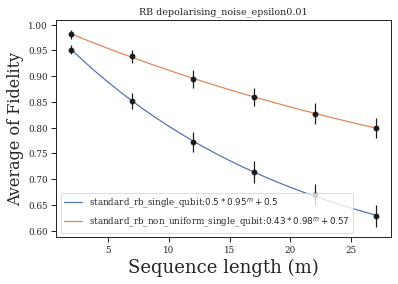

In [15]:
fig = plt.figure()
ax = fig.add_subplot()

for version in ['standard_rb_single_qubit', 'standard_rb_non_uniform_single_qubit']:
# for version in ['standard_rb_single_qubit', 'native_conditional_single_qubit']:
# for version in ['native_conditional_conditional_two_qubits']:
# for version in ['native_conditional_single_qubit']:
#     plot_bench_arrays(ax, version, epsilon)
    plot_decay(ordered_layers_dict[version][:], avg_fdlty_dict[version][:],
               err_fdlty_dict[version][:], label = version, axes = ax)

# plt.loglog()
ax.set_xlabel('Sequence length (m)', fontsize=18)
ax.set_ylabel('Average of Fidelity', fontsize=16)
ax.set_title(r'RB {}'.format(noisy_machine))

plt.legend()

fig.savefig(os.path.join(path, 'RB_{}.png'.format(target_qubits)))


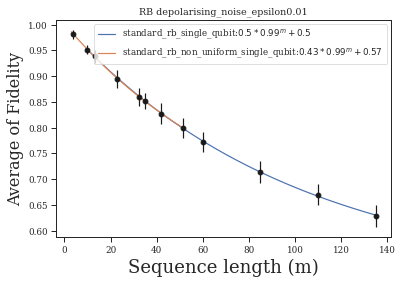

In [19]:
fig = plt.figure()
ax = fig.add_subplot()

plot_decay(ordered_layers_dict['standard_rb_single_qubit'][:]*5, avg_fdlty_dict['standard_rb_single_qubit'][:],
           err_fdlty_dict['standard_rb_single_qubit'][:], label = 'standard_rb_single_qubit', axes = ax)

plot_decay(ordered_layers_dict['standard_rb_non_uniform_single_qubit'][:]*1.91, avg_fdlty_dict['standard_rb_non_uniform_single_qubit'][:],
           err_fdlty_dict['standard_rb_non_uniform_single_qubit'][:], label = 'standard_rb_non_uniform_single_qubit', axes = ax)

# plt.loglog()
ax.set_xlabel('Sequence length (m)', fontsize=18)
ax.set_ylabel('Average of Fidelity', fontsize=16)
ax.set_title(r'RB {}'.format(noisy_machine))

plt.legend()

# fig.savefig(os.path.join(path, 'RB_{}.png'.format(target_qubits)))
